In [ ]:
# !pip install --quiet optuna
# !pip install --quiet stellargraph

In [1]:
import os
import optuna
from optuna.trial import TrialState

In [2]:
import pandas as pd
import numpy as np
import torch
import random
import math
import torch.optim as optim

# Data prep

In [3]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25
seq_len = 3
pre_len = 1

#adjacency matrix
grid_points = pd.read_csv('grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [4]:
def data_preparation(datafile):
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    # only PM2_5
    df = df[['dateTime','lat','long','pm2_5']]

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    df = df[(df.dateTime>=360)] 

    # only PM2_5
#     df = df[['dateTime','lat_grid','long_grid','pm2_5
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
    columns = df.columns
#     df = df[columns[2:]]
    df = df.fillna(0)
    
    return df

In [5]:
def train_test_split(df, grid_points_indices, train_size):
    # random.seed(10)
    time_len = df.shape[1]
    train_size = int(time_len * train_size) 
    train_data = df.iloc[:, :train_size]
    train_data = train_data.reindex(grid_points_indices,fill_value=0)
    train_data = np.array(train_data)
    test_data = df.iloc[:, train_size:]
    test_data = test_data.reindex(grid_points_indices,fill_value=0)
    test_data = np.array(test_data)
    return train_data, test_data

In [6]:
def scale_data(train_data, test_data):
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)
    test_scaled = (test_data - min_pm) / (max_pm - min_pm)
    return train_scaled, test_scaled

In [7]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [8]:
def prepare_train_data(df, grid_points_indices, train_size = 0.8):
    train_data, test_data = train_test_split(df, grid_points_indices, train_size)
    print("Train data: ", train_data.shape)
    print("Test data: ", test_data.shape)
    train_scaled, test_scaled = scale_data(train_data, test_data)
    trainX, trainY, testX, testY = sequence_data_preparation(
        seq_len, pre_len, train_scaled, test_scaled
    )
    print(trainX.shape)
    print(trainY.shape)
    print(testX.shape)
    print(testY.shape)
    return trainX, trainY, testX, testY, train_data

# Training

In [9]:
def my_loss(y_true, y_pred):
    loss = torch.mean((y_pred[y_true>0]-y_true[y_true>0])**2)
    return loss

In [10]:
def train_model(trainX, trainY, testX, testY, n_epochs, batch_size):
    #Training loop
    all_data = [(i, (trainX[i], trainY[i])) for i in range(len(trainX))]
    all_validation_data = [(testX[i], testY[i]) for i in range(len(testX))]
    n_data_points = trainX.shape[0]
    train_mse, train_rmse, validation_mse, validation_rmse=[], [], [], []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        batched_labels, batched_data=[], []
        running_loss = 0.0
        valid_loss = 0.0
        model.train()
        for i, data in all_data:
            # get the inputs; data is a list of [inputs, labels]
            input_data, labels = data
            batched_labels.append(labels)
            batched_data.append(input_data)
            if(((i%(batch_size-1)==0) and i!=0) or (i==(n_data_points-1))):
                # forward + backward + optimize
                model.train()
                outputs = model(torch.Tensor(batched_data))
                loss = my_loss(outputs, torch.Tensor(batched_labels))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss = running_loss+loss.item()*len(batched_data)
                batched_labels, batched_data=[], []
        model.eval()
        test_out = model(torch.Tensor(testX))
        loss = my_loss(test_out, torch.Tensor(testY))
        valid_loss = loss.item() #* len(data[0])
        running_loss = running_loss/len(all_data)
        train_mse.append(running_loss)
        train_rmse.append(math.sqrt(running_loss))
        validation_mse.append(valid_loss)
        validation_rmse.append(math.sqrt(valid_loss))
        if((epoch+1)%10==0):
            print(f'Epoch {epoch+1} \t Train Loss: ', {running_loss}, 'Valid Loss: ', {valid_loss})
    print('Finished Training')
    return train_mse, train_rmse, validation_mse, validation_rmse

In [11]:
def eval_model(model, testX, testY):
    output = model(torch.Tensor(testX))
    ## actual train and test values
    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    test_true = np.array((testY * (max_pm - min_pm)) + min_pm)
    ## Rescale model predicted values
    test_output = np.array((output.detach().numpy() * (max_pm - min_pm)) + min_pm)
    # # Masked predicted values\
    mask_test = torch.sign(torch.Tensor(testY))
    test_output = torch.Tensor(test_output)*(mask_test)
    test_mse = my_loss(torch.Tensor(test_true), torch.Tensor(test_output))
    test_rmse = torch.sqrt(test_mse)
    print("Test RMSE: ", test_rmse)
    return test_output, test_true

In [12]:
def get_out_df(train_rmse, validation_rmse):
    max_pm = train_data.max()
    min_pm = train_data.min()
    scale_factor = max_pm - min_pm
    df = pd.DataFrame()
    df['Mean Train loss'] = [sum(train_rmse)*scale_factor/len(train_rmse)]
    df['Last Train loss'] = [train_rmse[-1]*scale_factor]
    df['Mean Test loss'] = [sum(validation_rmse)*scale_factor/len(validation_rmse)]
    df['Last Test loss'] = [validation_rmse[-1]*scale_factor]
    # df['Train time callbacks'] = [sum(cb.logs)]
    return df

In [13]:
def plot_predictions(test_output, test_true, save_path=None):
    ##all test result visualization
    fig = plt.figure(figsize=(15, 8))
    # test_output, test_true = eval(model, testX, testY )
    a_pred = test_output[test_true>0]
    a_true = test_true[test_true>0]
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("test points")
    plt.ylabel("PM2.5")
    plt.legend(loc="best", fontsize=10)
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Initialize The Model

In [15]:
df = data_preparation('PM Datasets/2020-12-01_all.csv')
for i in range(2, 8):
    datafile = 'PM Datasets/2020-12-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = data_preparation(datafile)
    df = pd.concat([df,df1], axis=1)
    df = df.fillna(0)

In [16]:
trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = 0.86)

Train data:  (270, 36)
Test data:  (270, 6)
(33, 270, 3)
(33, 270)
(3, 270, 3)
(3, 270)


In [29]:
from gcn_lstm import GCN_LSTM
import numpy as np
import torch
adj = adj.astype(np.float32)
model=GCN_LSTM(torch.from_numpy(adj), grid_size = 270, seq_len = 3, gc_sizes = [4, 4], lstm_sizes = [4])
optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999), eps=1e-05)

Epoch 10 	 Train Loss:  {0.037273591102072685} Valid Loss:  {0.02031305991113186}
Epoch 20 	 Train Loss:  {0.02007698736181765} Valid Loss:  {0.012903207913041115}
Epoch 30 	 Train Loss:  {0.01951464203496774} Valid Loss:  {0.011291174218058586}
Epoch 40 	 Train Loss:  {0.018145629515250523} Valid Loss:  {0.010823999531567097}
Epoch 50 	 Train Loss:  {0.018180276972777916} Valid Loss:  {0.010598400607705116}
Epoch 60 	 Train Loss:  {0.016526807776906273} Valid Loss:  {0.010374492965638638}
Epoch 70 	 Train Loss:  {0.015390731732953678} Valid Loss:  {0.010356251150369644}
Epoch 80 	 Train Loss:  {0.016165326716321888} Valid Loss:  {0.010238747112452984}
Epoch 90 	 Train Loss:  {0.015190014220548399} Valid Loss:  {0.0103223267942667}
Epoch 100 	 Train Loss:  {0.01569116273612687} Valid Loss:  {0.010180806741118431}
Finished Training


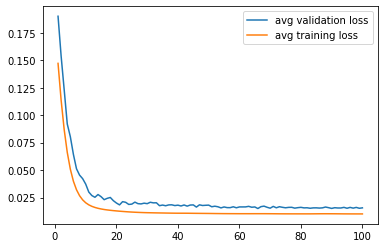

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,97.721115,82.256937,77.529187,66.257656


In [23]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

Epoch 10 	 Train Loss:  {0.057198152962056076} Valid Loss:  {0.04713565111160278}
Epoch 20 	 Train Loss:  {0.027303169791897137} Valid Loss:  {0.021051529794931412}
Epoch 30 	 Train Loss:  {0.02048668090366956} Valid Loss:  {0.015527441166341305}
Epoch 40 	 Train Loss:  {0.018166460887049183} Valid Loss:  {0.013512946665287018}
Epoch 50 	 Train Loss:  {0.017101635817777027} Valid Loss:  {0.012550750747323036}
Epoch 60 	 Train Loss:  {0.016925633574525516} Valid Loss:  {0.011966605670750141}
Epoch 70 	 Train Loss:  {0.01615344388692668} Valid Loss:  {0.011599073186516762}
Epoch 80 	 Train Loss:  {0.01626210484766599} Valid Loss:  {0.011339811608195305}
Epoch 90 	 Train Loss:  {0.01558724119130409} Valid Loss:  {0.011119083501398563}
Epoch 100 	 Train Loss:  {0.015536233613436872} Valid Loss:  {0.01099488791078329}
Finished Training


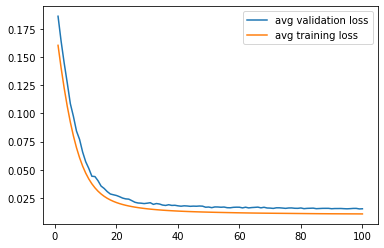

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,103.486617,81.849842,90.058489,68.855776


In [25]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

Epoch 10 	 Train Loss:  {0.0572163819363623} Valid Loss:  {0.048856914043426514}
Epoch 20 	 Train Loss:  {0.02811798814571265} Valid Loss:  {0.021774671971797943}
Epoch 30 	 Train Loss:  {0.020527551740859493} Valid Loss:  {0.015888961032032967}
Epoch 40 	 Train Loss:  {0.0179378173568032} Valid Loss:  {0.013792578130960464}
Epoch 50 	 Train Loss:  {0.017295955877864} Valid Loss:  {0.012781280092895031}
Epoch 60 	 Train Loss:  {0.016065531156279823} Valid Loss:  {0.012177462689578533}
Epoch 70 	 Train Loss:  {0.016539915549484165} Valid Loss:  {0.011780084110796452}
Epoch 80 	 Train Loss:  {0.01623795362132968} Valid Loss:  {0.011487873271107674}
Epoch 90 	 Train Loss:  {0.01573657656483578} Valid Loss:  {0.011273857206106186}
Epoch 100 	 Train Loss:  {0.015971009760643497} Valid Loss:  {0.011106111109256744}
Finished Training


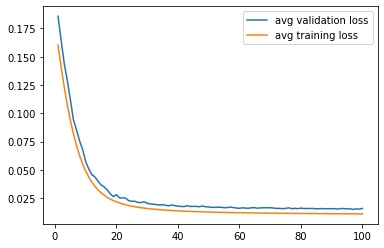

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,103.44741,82.987209,90.97933,69.203168


In [27]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

Epoch 10 	 Train Loss:  {0.04718943764314507} Valid Loss:  {0.026261337101459503}
Epoch 20 	 Train Loss:  {0.02481268797860001} Valid Loss:  {0.013977867551147938}
Epoch 30 	 Train Loss:  {0.020416718766544804} Valid Loss:  {0.011995132081210613}
Epoch 40 	 Train Loss:  {0.0172780112109401} Valid Loss:  {0.011239618994295597}
Epoch 50 	 Train Loss:  {0.01744050555156939} Valid Loss:  {0.010874168016016483}
Epoch 60 	 Train Loss:  {0.01720539757022352} Valid Loss:  {0.010734585113823414}
Epoch 70 	 Train Loss:  {0.01607883619991216} Valid Loss:  {0.010563905350863934}
Epoch 80 	 Train Loss:  {0.015641090375455944} Valid Loss:  {0.010433975607156754}
Epoch 90 	 Train Loss:  {0.01682480193223014} Valid Loss:  {0.010398793034255505}
Epoch 100 	 Train Loss:  {0.015790250716787396} Valid Loss:  {0.010387972928583622}
Finished Training


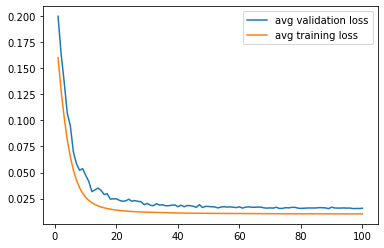

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,100.810096,82.51625,80.595326,66.92839


In [30]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

In [32]:
torch.manual_seed(0)
torch.randn(2, 4)

tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380]])

In [34]:
torch.manual_seed(0)
torch.randn(2, 4)

tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
        [-1.0845, -1.3986,  0.4033,  0.8380]])